In [1]:
import pandas as pd
import numpy as np

In [2]:
clinical_patient_df = pd.read_csv('clinical_patient_data.csv')
clinical_sample_df = pd.read_csv('clinical_sample_data.csv')
cna_df_f = pd.read_csv('linear_cna_data.csv')
methylation_df_f = pd.read_csv('methylation_hm450_data.csv')
mrna_df_f = pd.read_csv('data_mrna_seq_v2_rsem_data.csv')

In [3]:
df = clinical_patient_df
df = df.iloc[4:]
df = df[['Patient Identifier', 'Diagnosis Age', 'Overall Survival Status', 'Overall Survival (Months)']].copy()
df.loc[:, 'Overall_Survival_Status'] = df['Overall Survival Status'].str.split(':').str[0].astype(int)
df.loc[:, 'Diagnosis_Age'] = df['Diagnosis Age']
df.loc[:, 'Overall_Survival_Months'] = df['Overall Survival (Months)']
df = df[['Patient Identifier', 'Diagnosis_Age', 'Overall_Survival_Status', 'Overall_Survival_Months']]

df['Overall_Survival_Months'] = pd.to_numeric(df['Overall_Survival_Months'], errors='coerce')
df['Overall_Survival_Status'] = pd.to_numeric(df['Overall_Survival_Status'], errors='coerce')

df = df.dropna(subset=['Overall_Survival_Months', 'Overall_Survival_Status'])
clinical_patient_df  = df


In [4]:
df_final = df[['Patient Identifier', 'Diagnosis_Age', 'Overall_Survival_Status','Overall_Survival_Months']]
df = df_final
df

,Patient Identifier,Diagnosis_Age,Overall_Survival_Status,Overall_Survival_Months
4,TCGA-2F-A9KO,63,1,24.11
5,TCGA-2F-A9KP,66,1,11.96
6,TCGA-2F-A9KQ,69,0,94.81
7,TCGA-2F-A9KR,59,1,104.57
8,TCGA-2F-A9KT,83,0,108.87
...,...,...,...,...
411,TCGA-ZF-AA56,79,1,8.51
412,TCGA-ZF-AA58,61,0,54.17
413,TCGA-ZF-AA5H,60,0,29.47
414,TCGA-ZF-AA5N,62,1,5.52


In [5]:
!pip install lifelines

Checking for NaN values in the dataset:
Patient Identifier         0
Diagnosis_Age              0
Overall_Survival_Status    0
Overall_Survival_Months    0
dtype: int64


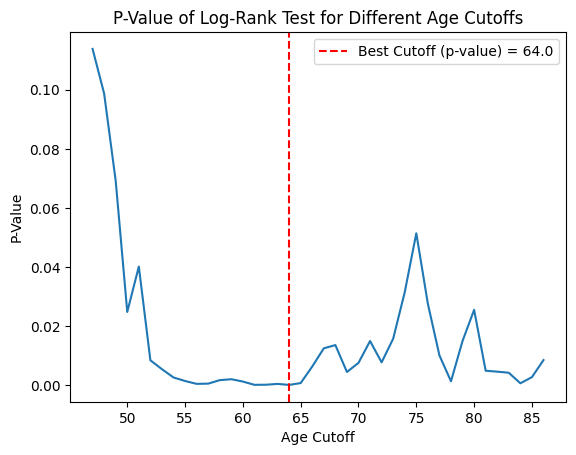

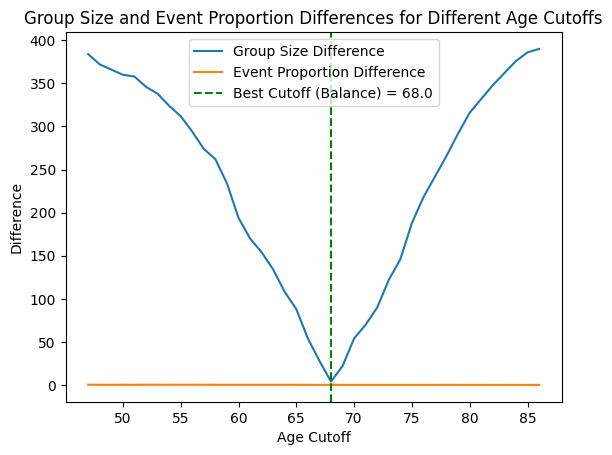

Best Cutoff based on Class Balance: 68.0
Best Cutoff based on P-Value: 64.0
Class Balance at Best Cutoff (Balance): Younger: 0.3793103448275862, Older: 0.4975845410628019


In [6]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

print("Checking for NaN values in the dataset:")
print(df.isnull().sum())  
df = df.dropna(subset=['Diagnosis_Age', 'Overall_Survival_Months', 'Overall_Survival_Status'])

df['Diagnosis_Age'] = pd.to_numeric(df['Diagnosis_Age'], errors='coerce')

df = df.dropna(subset=['Diagnosis_Age'])

age_cutoffs = np.arange(34, 90, 1)
p_values = []
class_balance = []
event_proportion_differences = []
group_sizes = []

for age_cutoff in age_cutoffs:
    younger_group = df[df['Diagnosis_Age'] <= age_cutoff]
    older_group = df[df['Diagnosis_Age'] > age_cutoff]

    if len(younger_group) < 10 or len(older_group) < 10:
        continue

    younger_event_proportion = younger_group['Overall_Survival_Status'].mean()
    older_event_proportion = older_group['Overall_Survival_Status'].mean()

    younger_group_size = len(younger_group)
    older_group_size = len(older_group)

    class_balance.append((age_cutoff, younger_event_proportion, older_event_proportion))
    group_sizes.append((age_cutoff, younger_group_size, older_group_size))

    kmf_younger = KaplanMeierFitter()
    kmf_older = KaplanMeierFitter()

    kmf_younger.fit(younger_group['Overall_Survival_Months'], younger_group['Overall_Survival_Status'])
    kmf_older.fit(older_group['Overall_Survival_Months'], older_group['Overall_Survival_Status'])

    # Log-rank test to compare survival curves
    results = logrank_test(younger_group['Overall_Survival_Months'],
                           older_group['Overall_Survival_Months'],
                           event_observed_A=younger_group['Overall_Survival_Status'],
                           event_observed_B=older_group['Overall_Survival_Status'])

    p_values.append((age_cutoff, results.p_value))

    group_size_diff = abs(younger_group_size - older_group_size)
    event_proportion_diff = abs(younger_event_proportion - older_event_proportion)

    event_proportion_differences.append((age_cutoff, group_size_diff, event_proportion_diff))

p_values_df = pd.DataFrame(p_values, columns=['Age_Cutoff', 'p_value'])
class_balance_df = pd.DataFrame(class_balance, columns=['Age_Cutoff', 'Younger_Event_Proportion', 'Older_Event_Proportion'])
event_proportion_diff_df = pd.DataFrame(event_proportion_differences, columns=['Age_Cutoff', 'Group_Size_Difference', 'Event_Proportion_Difference'])
group_sizes_df = pd.DataFrame(group_sizes, columns=['Age_Cutoff', 'Younger_Group_Size', 'Older_Group_Size'])

best_cutoff_balance = event_proportion_diff_df.loc[event_proportion_diff_df['Group_Size_Difference'].idxmin()]

best_cutoff_p_value = p_values_df.loc[p_values_df['p_value'].idxmin()]

# Plot the p-values
plt.plot(p_values_df['Age_Cutoff'], p_values_df['p_value'])
plt.axvline(x=best_cutoff_p_value['Age_Cutoff'], color='red', linestyle='--', label=f'Best Cutoff (p-value) = {best_cutoff_p_value["Age_Cutoff"]}')
plt.title('P-Value of Log-Rank Test for Different Age Cutoffs')
plt.xlabel('Age Cutoff')
plt.ylabel('P-Value')
plt.legend()
plt.show()

plt.plot(event_proportion_diff_df['Age_Cutoff'], event_proportion_diff_df['Group_Size_Difference'], label='Group Size Difference')
plt.plot(event_proportion_diff_df['Age_Cutoff'], event_proportion_diff_df['Event_Proportion_Difference'], label='Event Proportion Difference')
plt.axvline(x=best_cutoff_balance['Age_Cutoff'], color='green', linestyle='--', label=f'Best Cutoff (Balance) = {best_cutoff_balance["Age_Cutoff"]}')
plt.title('Group Size and Event Proportion Differences for Different Age Cutoffs')
plt.xlabel('Age Cutoff')
plt.ylabel('Difference')
plt.legend()
plt.show()

print(f"Best Cutoff based on Class Balance: {best_cutoff_balance['Age_Cutoff']}")
print(f"Best Cutoff based on P-Value: {best_cutoff_p_value['Age_Cutoff']}")
print(f"Class Balance at Best Cutoff (Balance): Younger: {class_balance_df[class_balance_df['Age_Cutoff'] == best_cutoff_balance['Age_Cutoff']]['Younger_Event_Proportion'].values[0]}, "
      f"Older: {class_balance_df[class_balance_df['Age_Cutoff'] == best_cutoff_balance['Age_Cutoff']]['Older_Event_Proportion'].values[0]}")


In [7]:

p_value_64 = p_values_df[p_values_df['Age_Cutoff'] == 64.0]['p_value'].values[0]
p_value_68 = p_values_df[p_values_df['Age_Cutoff'] == 68.0]['p_value'].values[0]

p_value_69 = p_values_df[p_values_df['Age_Cutoff'] == 70.0]['p_value'].values[0]


print(f"P-Value at Cutoff 64: {p_value_64}")
print(f"P-Value at Cutoff 68: {p_value_68}")
print(f"P-Value at Cutoff 69: {p_value_69}")

P-Value at Cutoff 64: 0.00010812785336540604
P-Value at Cutoff 68: 0.013592655190891865
P-Value at Cutoff 69: 0.007571968542211809


In [8]:
def plot_kaplan_meier_cutoff(df, cutoff):
    younger_group = df[df['Diagnosis_Age'] < cutoff]
    older_group = df[df['Diagnosis_Age'] >= cutoff]

    num_younger = younger_group.shape[0]
    num_older = older_group.shape[0]

    count_below_cutoff = df[df['Diagnosis_Age'] < cutoff].shape[0]
    count_above_cutoff = df[df['Diagnosis_Age'] >= cutoff].shape[0]

    kmf_younger = KaplanMeierFitter()
    kmf_older = KaplanMeierFitter()

    kmf_younger.fit(younger_group['Overall_Survival_Months'], younger_group['Overall_Survival_Status'], label='Younger Group')
    kmf_older.fit(older_group['Overall_Survival_Months'], older_group['Overall_Survival_Status'], label='Older Group')

    plt.figure(figsize=(10, 6))
    kmf_younger.plot_survival_function()
    kmf_older.plot_survival_function()
    plt.title(f'Kaplan-Meier Survival Curves for Age Cutoff {cutoff}')
    plt.xlabel('Months')
    plt.ylabel('Survival Probability')
    plt.legend()
    plt.grid()
    plt.show()

    # Log-rank test to compare survival curves
    results = logrank_test(younger_group['Overall_Survival_Months'],
                           older_group['Overall_Survival_Months'],
                           event_observed_A=younger_group['Overall_Survival_Status'],
                           event_observed_B=older_group['Overall_Survival_Status'])

    return {
        'p_value': results.p_value,
        'num_younger': num_younger,
        'num_older': num_older,
        'count_below_cutoff': count_below_cutoff,
        'count_above_cutoff': count_above_cutoff,
    }


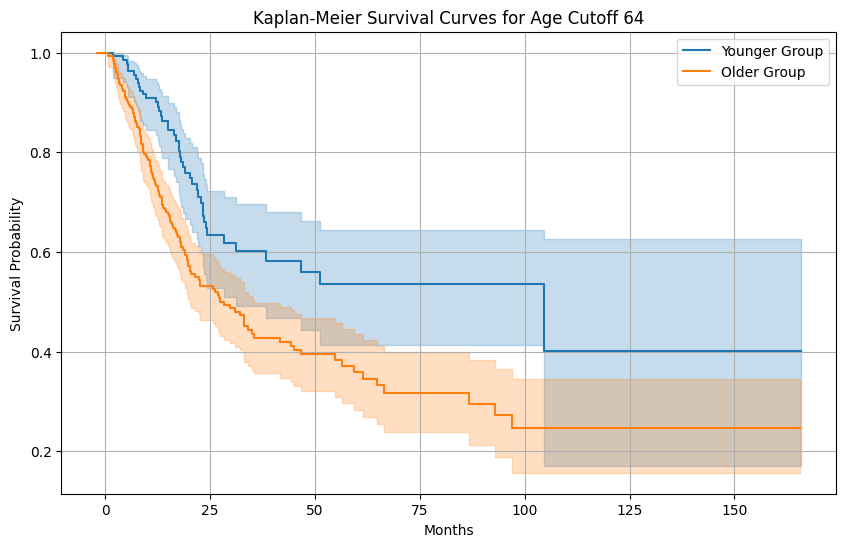

Results for cutoff at 64:
P-value: 0.0004545310103853482
Number of samples < 64: 138
Number of samples >= 64: 272
Total Samples: 410


In [9]:
results_cutoff_64 = plot_kaplan_meier_cutoff(df, 64)

print(f"Results for cutoff at 64:")
print(f"P-value: {results_cutoff_64['p_value']}")
print(f"Number of samples < 64: {results_cutoff_64['count_below_cutoff']}")
print(f"Number of samples >= 64: {results_cutoff_64['count_above_cutoff']}")
print(f"Total Samples: {results_cutoff_64['num_younger'] + results_cutoff_64['num_older']}")



In [10]:
num = 64
df['Age_Above_'+str(num)] = df['Diagnosis_Age'].apply(lambda x: 1 if x >= num else 0)
df

,Patient Identifier,Diagnosis_Age,Overall_Survival_Status,Overall_Survival_Months,Age_Above_64
4,TCGA-2F-A9KO,63,1,24.11,0
5,TCGA-2F-A9KP,66,1,11.96,1
6,TCGA-2F-A9KQ,69,0,94.81,1
7,TCGA-2F-A9KR,59,1,104.57,0
8,TCGA-2F-A9KT,83,0,108.87,1
...,...,...,...,...,...
411,TCGA-ZF-AA56,79,1,8.51,1
412,TCGA-ZF-AA58,61,0,54.17,0
413,TCGA-ZF-AA5H,60,0,29.47,0
414,TCGA-ZF-AA5N,62,1,5.52,0


In [11]:
!pip install statsmodels

In [12]:
import pandas as pd

def process_dataframe(df):
    df.reset_index(inplace=False)
    df = df.transpose()
    df.columns = df.iloc[0, :]
    df = df.iloc[2:, :]
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'Patient_ID'}, inplace=True)
    return df

cna_df = process_dataframe(cna_df_f)
mrna_df = process_dataframe(mrna_df_f)
methylation_df = process_dataframe(methylation_df_f)

In [13]:
cna_df['Patient_ID'] = cna_df['Patient_ID'].str.replace(r'-01$', '', regex=True)
mrna_df['Patient_ID'] = mrna_df['Patient_ID'].str.replace(r'-01$', '', regex=True)
methylation_df['Patient_ID'] = methylation_df['Patient_ID'].str.replace(r'-01$', '', regex=True)

In [14]:
import pandas as pd

def merge_with_target(temp_df, df, identifier_temp='Patient_ID', identifier_df='Patient Identifier', target_column='Age_Above_64'):
    temp_df_merged = pd.merge(temp_df, df[[identifier_df, target_column]], how='left', left_on=identifier_temp, right_on=identifier_df)
    return temp_df_merged


df_cna_merged = merge_with_target(cna_df, df)
df_mrna_merged = merge_with_target(mrna_df, df)
df_methylation_merged = merge_with_target(methylation_df, df)


In [15]:
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

def preprocess(df, identifier='Patient_ID', target='Age_Above_64'):
    identifier_column = df[identifier]
    target_column = df[target]

    df_without_id_target = df.drop(columns=[identifier, target])

    df_without_id_target = df_without_id_target.apply(pd.to_numeric, errors='coerce')

    df_without_id_target.columns = df_without_id_target.columns.astype(str)

    df_without_id_target = df_without_id_target.drop(columns=['Patient Identifier'], errors='ignore')

    print(f"Data Types After Conversion to Numeric:\n{df_without_id_target.dtypes}")

    columns_with_all_nan = df_without_id_target.columns[df_without_id_target.isna().all()].tolist()
    if columns_with_all_nan:
        print(f"Columns with all NaN values: {columns_with_all_nan}")
        df_without_id_target = df_without_id_target.drop(columns=columns_with_all_nan)

    imputer = SimpleImputer(strategy='median')
    df_processed_imputed = imputer.fit_transform(df_without_id_target)

    df_processed = pd.DataFrame(df_processed_imputed, columns=df_without_id_target.columns)

    duplicate_columns = df_processed.columns[df_processed.columns.duplicated(keep=False)]
    dropped_columns = []

    for col in duplicate_columns.unique():
        duplicate_set = df_processed.filter(like=col, axis=1)
        variances = duplicate_set.var()
        best_column = variances.idxmax()
        to_drop = [c for c in duplicate_set.columns if c != best_column]
        dropped_columns.extend(to_drop)
        df_processed = df_processed.drop(columns=to_drop)

    print(f"Dropped duplicate columns: {dropped_columns}")

    # Add back the identifier and target columns
    df_processed[identifier] = identifier_column
    df_processed[target] = target_column

    return df_processed
    
df_cna_processed = preprocess(df_cna_merged, identifier='Patient_ID', target='Age_Above_64')
df_mrna_processed = preprocess(df_mrna_merged, identifier='Patient_ID', target='Age_Above_64')
df_methylation_processed = preprocess(df_methylation_merged, identifier='Patient_ID', target='Age_Above_64')

Data Types After Conversion to Numeric:
ACAP3                        float64
ACTRT2                       float64
AGRN                         float64
ANKRD65                      float64
ATAD3A                       float64
                              ...   
IL9R|ENSG00000124334.12      float64
SPRY3|ENSG00000168939.6      float64
VAMP7|ENSG00000124333.10     float64
WASH6P|ENSG00000182484.10    float64
WASIR1|ENSG00000185203.7     float64
Length: 24776, dtype: object
Dropped duplicate columns: ['TRAPPC2L']
Data Types After Conversion to Numeric:
LOC100130426    float64
UBE2Q2P3        float64
UBE2Q2P3        float64
HMGB1P1         float64
TIMM23          float64
                 ...   
ZYX             float64
FLJ10821        float64
ZZZ3            float64
TPTEP1          float64
AKR1C6P         float64
Length: 20531, dtype: object
Columns with all NaN values: ['MOXD2', 'LOC317712', 'REXO1L6P', 'PPBPL1', 'BSPH1', 'C11orf40', 'SPACA7', 'CDY1', 'CT47A11', 'DEFB105A', 'DEFB106A', 'DE

In [16]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold


def force_numeric_conversion(df, exclude_columns):
    """Force convert all non-excluded columns to numeric."""
    numeric_df = df.drop(columns=exclude_columns, errors='ignore').apply(
        pd.to_numeric, errors='coerce'
    )
    
    failed_conversions = numeric_df.columns[numeric_df.isna().all()]
    if not failed_conversions.empty:
        print(f"Warning: Could not convert columns to numeric: {failed_conversions.tolist()}")
    
    return numeric_df


def robust_preprocessor(df, identifier=None, target=None):
    metadata_cols = []
    if identifier:
        metadata_cols.append(identifier)
    if target:
        metadata_cols.append(target)
        
    metadata = df[metadata_cols] if metadata_cols else pd.DataFrame(index=df.index)
    
    data_only = force_numeric_conversion(df, metadata_cols)
    
    selector = VarianceThreshold()
    selected_data = pd.DataFrame(selector.fit_transform(data_only), 
                                 index=data_only.index, 
                                 columns=data_only.columns[selector.get_support()])
    
    min_val = selected_data.min().min()
    if min_val <= 0:
        shift_value = abs(min_val) + 1  
        selected_data += shift_value
    log_transformed = np.log1p(selected_data)
    
    scaler = StandardScaler()
    standardized = pd.DataFrame(scaler.fit_transform(log_transformed),
                                 index=log_transformed.index,
                                 columns=log_transformed.columns)
    
    return pd.concat([standardized, metadata], axis=1)


df_cna_transform = robust_preprocessor(df_cna_processed, identifier="Patient_ID", target="Age_Above_64")
df_mrna_transform = robust_preprocessor(df_mrna_processed, identifier="Patient_ID", target="Age_Above_64")
df_methylation_transform = robust_preprocessor(df_methylation_processed, identifier="Patient_ID", target="Age_Above_64")


In [54]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

def process_omics_data(df, y_col, variance_threshold=0.1, 
                      feature_percentile=5, l1_penalty=0.1,
                      stability_threshold='median'):
    
    df = df.dropna(subset=[y_col])  
    y = df[y_col]
    X = df.drop(columns=[y_col, 'Patient_ID'], errors='ignore')

    # Rest of the pipeline remains the same
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('variance', VarianceThreshold(threshold=variance_threshold)),
        ('scaler', StandardScaler()),
        ('univariate', SelectPercentile(score_func=f_classif, 
                                      percentile=feature_percentile)),
        ('l1_selection', SelectFromModel(
            LogisticRegression(penalty='l1', solver='saga',
                              class_weight='balanced', C=l1_penalty,
                              max_iter=5000, tol=1e-3),
            threshold=stability_threshold
        )),
    ])

    X_transformed = pipeline.fit_transform(X, y)
    
    features = X.columns
    for step in ['variance', 'univariate', 'l1_selection']:
        features = features[pipeline.named_steps[step].get_support()]
    
    result_df = pd.DataFrame(X_transformed, index=X.index, columns=features)
    
    if 'Patient_ID' in df.columns:
        result_df['Patient_ID'] = df['Patient_ID']
    
    return result_df

cna_selected = process_omics_data(df_cna_transform, y_col='Age_Above_64')
mrna_selected = process_omics_data(df_mrna_transform, y_col='Age_Above_64')
methyl_selected = process_omics_data(df_methylation_transform, y_col='Age_Above_64')

print(cna_selected.shape)
print(mrna_selected.shape)
print(methyl_selected.shape)

(406, 1240)
(406, 1010)
(410, 812)


In [55]:
cna_selected = cna_selected.merge(df_cna_processed[["Patient_ID", "Age_Above_64"]], on="Patient_ID")
mrna_selected = mrna_selected.merge(df_cna_processed[["Patient_ID", "Age_Above_64"]], on="Patient_ID")
methyl_selected = methyl_selected.merge(df_cna_processed[["Patient_ID", "Age_Above_64"]], on="Patient_ID")

In [56]:
cna_selected

,RRAGC,MYCBP,GJA9,RHBDL2,AKIRIN1,NDUFS5,MACF1,RNA5SP44,KIAA0754,BMP8A,...,TRAPPC10,PWP2,C21orf33,ICOSLG,DNMT3L,AIRE,PFKL,C21orf2,Patient_ID,Age_Above_64
0,-0.895117,-0.896812,-0.896812,-0.887238,-0.887930,-0.862042,-0.816823,-0.845288,-0.812655,-0.816823,...,-0.854537,-0.854537,-0.851622,-0.850705,-0.852881,-0.852881,-0.852881,-0.852881,TCGA-2F-A9KO,0.0
1,-1.286430,-1.287356,-1.287356,3.721846,3.665584,3.471728,3.027044,3.248818,3.031711,3.027044,...,-0.108539,-0.108539,-0.104784,-0.104064,-0.105671,-0.105671,-0.105671,-0.105671,TCGA-2F-A9KP,1.0
2,-0.212734,-0.215769,-0.215769,-0.236700,-0.245234,-0.250362,-0.274289,-0.267435,-0.270051,-0.274289,...,1.858979,1.858979,1.864947,1.865147,1.865043,1.865043,1.865043,1.865043,TCGA-2F-A9KQ,1.0
3,-0.476893,-0.479409,-0.479409,-0.488531,-0.494029,-0.487150,-0.484311,-0.491129,-0.480099,-0.484311,...,-0.017154,-0.017154,-0.013296,-0.012601,-0.014138,-0.014138,-0.014138,-0.014138,TCGA-2F-A9KR,0.0
4,-0.125303,-0.128510,-0.128510,-0.153349,-0.162888,-0.171990,-0.204777,-0.193397,-0.200529,-0.204777,...,-0.099934,-0.099934,-0.096169,-0.095452,-0.097052,-0.097052,-0.097052,-0.097052,TCGA-2F-A9KT,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,-0.157269,-0.160413,-0.160413,-0.183823,-0.192995,-0.200643,-0.230191,-0.220466,-0.225947,-0.230191,...,-0.863855,-0.863855,-0.860950,-0.860032,-0.862215,-0.862215,-0.862215,-0.862215,TCGA-ZF-AA56,1.0
402,-0.067455,-0.070775,-0.070775,-0.098200,-0.108404,-0.120135,-0.158784,-0.144410,-0.154530,-0.158784,...,-0.370385,-0.370385,-0.366925,-0.366136,-0.367943,-0.367943,-0.367943,-0.367943,TCGA-ZF-AA58,0.0
403,0.152067,0.148315,0.148315,0.111078,0.098350,0.076642,0.015748,0.041485,0.020025,0.015748,...,-1.260492,-1.260492,-1.258033,-1.257010,-1.259496,-1.259496,-1.259496,-1.259496,TCGA-ZF-AA5H,0.0
404,-0.189341,-0.192422,-0.192422,-0.214398,-0.223202,-0.229393,-0.255691,-0.247626,-0.251450,-0.255691,...,-0.157448,-0.157448,-0.153748,-0.153015,-0.154659,-0.154659,-0.154659,-0.154659,TCGA-ZF-AA5N,0.0


In [20]:
mrna_selected

,A1BG,AASDH,ABCA5,ABCC4,ABCC9,ACTG2,ACTL8,ACTN3,ACVR1C,ADAM12,...,ZNF385D,ZNF492,ZNF658,ZNF75D,ZNF816,ZNF833P,ZNFX1,ZSWIM6,Patient_ID,Age_Above_64
0,-0.280236,-0.053186,0.552145,1.294890,0.313377,0.903857,2.174961,-1.195259,0.531237,0.106703,...,-0.536652,0.513442,-0.288057,1.515343,0.544681,-0.981067,1.467105,-0.203098,TCGA-2F-A9KO,0.0
1,-1.024185,0.821659,-0.667586,0.157732,-0.957045,-0.574168,1.890129,-1.195259,0.909918,-1.535713,...,0.037165,1.549955,0.652842,-0.177261,0.483514,0.588341,-0.460946,-0.122218,TCGA-2F-A9KP,1.0
2,-0.633363,0.722319,0.662035,0.220237,-0.544472,-0.486732,-0.617619,-0.501107,-1.962263,-0.250896,...,-0.825522,-0.557115,-0.907459,0.543241,1.436576,0.292793,-0.897545,0.986623,TCGA-2F-A9KQ,1.0
3,-0.385475,0.381073,2.045912,0.288404,-0.165431,0.631159,0.314117,-1.195259,1.536253,-0.898553,...,-1.043239,1.002064,0.765627,1.410308,0.458844,0.701754,0.510075,1.121572,TCGA-2F-A9KR,0.0
4,-0.902492,-1.437064,1.052619,-1.656852,-0.379819,-0.069440,-0.375508,-0.378932,0.089792,0.341782,...,-1.359903,-0.629349,0.277404,-0.351137,-0.506772,0.755555,0.378844,0.191433,TCGA-2F-A9KT,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,-0.064416,0.134345,0.558611,0.557079,-0.327008,0.329026,-0.319735,-0.529286,0.283336,0.185257,...,0.530572,-0.874728,-0.586716,0.182638,-0.204118,-0.608249,0.360589,0.097804,TCGA-ZF-AA56,1.0
398,0.154288,-0.867096,-1.857515,0.011619,0.199416,0.818663,-0.863499,0.600527,-1.982424,0.504390,...,-0.085414,-0.883304,-1.091008,-0.651574,-0.523459,-0.435223,1.048139,0.520167,TCGA-ZF-AA58,0.0
399,-0.743481,0.613653,-1.145932,-1.769373,1.453257,0.278597,-0.425905,-0.286372,-0.360049,0.746430,...,-0.576556,-1.104350,-0.588420,-0.171271,-1.100207,-0.575033,1.233627,0.463620,TCGA-ZF-AA5H,0.0
400,-1.301730,0.259843,1.198661,-1.684097,-1.997123,-1.275110,1.356975,-1.195259,-2.226350,-1.791578,...,-1.359903,-1.104350,0.092442,-1.682175,-0.124704,-0.473617,0.669919,-0.416423,TCGA-ZF-AA5N,0.0


In [21]:
methyl_selected

,NDOR1,MYOZ1,ADAMTSL1,PTPN14,IGFN1,TRIOBP,HSD17B8,TNFRSF10B,IL23A,GFOD2,...,DNMBP,TRERF1,LARP6,FAM174B,LOC100188949,MAP1LC3A,MKL2,USP47,Patient_ID,Age_Above_64
0,1.009686,0.148813,0.220814,0.732109,-0.058335,0.711397,-0.411754,0.366183,-0.476054,0.741770,...,0.534071,-0.063018,-0.304092,0.113104,-0.464813,-0.292784,0.851271,-0.612955,TCGA-2F-A9KO,0.0
1,-0.509065,-0.364669,-1.511614,0.565049,-0.821212,-0.608493,-0.841835,1.013162,1.741473,-1.287375,...,0.482841,-0.572003,-0.045259,-0.149893,0.356787,0.693897,-0.617283,-0.445204,TCGA-2F-A9KP,1.0
2,-2.008848,0.389602,0.791213,-0.880040,-1.081325,-1.633041,-1.269525,-1.858259,-0.592240,-1.279677,...,-1.000697,-1.205563,-0.176092,-1.835947,0.974658,1.203037,-1.857489,-1.093550,TCGA-2F-A9KQ,1.0
3,-0.851568,0.437799,0.424301,-1.585182,-0.895141,-1.269234,-1.077632,-1.391079,-0.936962,-0.959632,...,0.750087,-0.407816,-0.400115,-1.150351,1.184564,-1.880456,-1.082376,-0.412463,TCGA-2F-A9KR,0.0
4,-0.182019,0.177055,-1.520891,0.879736,0.310227,0.064159,0.519143,0.052452,-0.527843,0.844197,...,0.359323,-0.064830,-1.199107,-0.031343,-0.083010,-0.488059,0.287087,0.116959,TCGA-2F-A9KT,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,0.239343,0.044008,0.248491,0.478393,0.238252,0.412617,-0.073126,-0.009481,-0.672302,0.494144,...,0.646399,0.435752,0.157630,1.031687,-0.312229,0.335063,0.091875,-0.122293,TCGA-ZF-AA56,1.0
402,0.833041,0.254091,0.379860,0.160117,0.279057,1.257568,-0.242413,0.599760,-0.746197,1.002832,...,0.347752,1.791065,-1.134274,1.084277,-1.031660,0.916599,1.301775,-0.418116,TCGA-ZF-AA58,0.0
403,-0.481269,-0.116843,-0.107316,-1.415818,-0.221725,0.097147,-0.842136,-0.273251,-1.011741,0.676364,...,-1.843915,-0.785873,-1.430925,-0.694867,-0.495080,0.571386,0.421827,1.141193,TCGA-ZF-AA5H,0.0
404,1.540015,0.278314,-0.070323,-1.580801,-0.632586,-1.250242,-0.413363,0.888739,1.865151,0.860084,...,-1.553895,-0.372274,1.241274,-0.728833,1.012956,1.430818,-0.438095,0.198240,TCGA-ZF-AA5N,0.0


In [57]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from scipy.stats import kruskal

# Custom function for Kruskal-Wallis test scoring
def kruskal_scorer(X, y):
    scores, pvalues = [], []
    for i in range(X.shape[1]):
        feature = X[:, i]
        grouped_data = [feature[y == cls] for cls in np.unique(y)]
        try:
            stat, p = kruskal(*grouped_data)
        except ValueError:
            # Handle cases where all groups have identical values
            stat, p = 0, 1
        scores.append(stat)
        pvalues.append(p)
    return np.array(scores), np.array(pvalues)

# Define the pipeline
def create_pipeline():
    return Pipeline([
        # 1. Impute missing values using median strategy
        ('imputer', SimpleImputer(strategy='median')),
        
        # 2. Kruskal-Wallis test for initial feature selection
        ('kruskal_filter', SelectKBest(score_func=kruskal_scorer, k=10)),
        
        # 3. LDA with regularization and 4. RFE for final feature selection
        ('rfe', RFE(estimator=LinearDiscriminantAnalysis(solver='lsqr', 
                                                       shrinkage='auto'), 
                   n_features_to_select=5))
    ])

# Function to apply the pipeline to a dataframe
def apply_pipeline(df, target_column):
    # Separate features and target
    X = df.drop(columns=[target_column, "Patient_ID"]).values
    y = df[target_column].values
    
    # Create and fit the pipeline
    pipeline = create_pipeline()
    pipeline.fit(X, y)
    
    # Get selected features
    kruskal_features = np.where(pipeline.named_steps['kruskal_filter'].get_support())[0]
    rfe_features = np.where(pipeline.named_steps['rfe'].get_support())[0]
    
    # Map selected features back to column names
    feature_names = df.drop(columns=[target_column, "Patient_ID"]).columns
    kruskal_selected = feature_names[kruskal_features].tolist()
    rfe_selected = feature_names[rfe_features].tolist()
    
    return kruskal_selected, rfe_selected

# Apply the pipeline to each dataframe
cna_kruskal, cna_rfe = apply_pipeline(cna_selected, "Age_Above_64")
mrna_kruskal, mrna_rfe = apply_pipeline(mrna_selected, "Age_Above_64")
methyl_kruskal, methyl_rfe = apply_pipeline(methyl_selected, "Age_Above_64")

# Print results
print("CNA Data - Features selected after Kruskal-Wallis:", cna_kruskal)
print("CNA Data - Final features selected by RFE:", cna_rfe)

print("mRNA Data - Features selected after Kruskal-Wallis:", mrna_kruskal)
print("mRNA Data - Final featuresa selected by RFE:", mrna_rfe)

print("Methylation Data - Features selected after Kruskal-Wallis:", methyl_kruskal)
print("Methylation Data - Final features selected by RFE:", methyl_rfe)

CNA Data - Features selected after Kruskal-Wallis: ['SLAMF7', 'OSTC', 'ETNPPL', 'ANK2', 'RN7SL184P', 'CAMK2D', 'ARSJ', 'SON', 'DONSON', 'CRYZL1']
CNA Data - Final features selected by RFE: ['RRAGC', 'RHBDL2', 'MACF1', 'RNA5SP44', 'KIAA0754']
mRNA Data - Features selected after Kruskal-Wallis: ['B4GALT3', 'C4orf33', 'FAM111A', 'GNPDA1', 'KCNK2', 'LRP3', 'LRRC49', 'PI15', 'ARHGEF28', 'SSTR5']
mRNA Data - Final featuresa selected by RFE: ['A1BG', 'ABCA5', 'ABCC4', 'ABCC9', 'ACTL8']
Methylation Data - Features selected after Kruskal-Wallis: ['TRIM14', 'KIF25', 'CLEC2B', 'ACCN3', 'TACR1', 'RPS6KA1', 'GSDMB', 'PLVAP', 'GPR133', 'HLA-H']
Methylation Data - Final features selected by RFE: ['ADAMTSL1', 'IGFN1', 'TRIOBP', 'TNFRSF10B', 'GFOD2']


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from scipy import stats
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from joblib import Parallel, delayed

def analyze_relevant_features(
    df,
    target_column='Age_Above_64',
    identifier_column='Patient_ID',
    max_features_range=(1, 20),
    p_value_threshold=0.2,
    verbose=True,
    n_jobs=-1
):
    
    if target_column not in df.columns or identifier_column not in df.columns:
        raise ValueError(f"Columns {target_column} or {identifier_column} not found.")
    if len(df.columns) < 3:
        raise ValueError("Insufficient features in the dataset.")

    print("\nStarting cleaning preprocessing...")
    df_cleaned = df.drop(columns=[identifier_column])
    y = df_cleaned[target_column]
    X = df_cleaned.drop(columns=[target_column])

    numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Impute missing values
    if numerical_cols:
        X[numerical_cols] = SimpleImputer(strategy='median').fit_transform(X[numerical_cols])
    if categorical_cols:
        X[categorical_cols] = SimpleImputer(strategy='most_frequent').fit_transform(X[categorical_cols])

    # Encode categorical features
    if categorical_cols:
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        encoded_data = encoder.fit_transform(X[categorical_cols])
        encoded_columns = encoder.get_feature_names_out(categorical_cols)
        X = pd.concat([X.drop(columns=categorical_cols), 
                      pd.DataFrame(encoded_data, columns=encoded_columns)], axis=1)

    # Final dataset preparation
    df_cleaned = pd.concat([X, y], axis=1).dropna(subset=[target_column])
    X = df_cleaned.drop(columns=[target_column])
    y = df_cleaned[target_column].apply(lambda x: 1 if x >= 64 else 0) if y.nunique() > 2 else df_cleaned[target_column]

    # Feature Selection Methods
    methods = {}
    
    # 1. Kruskal-Wallis test
    def kruskal_test():
        selected = []
        for col in X.columns:
            group0 = X.loc[y == 0, col]
            group1 = X.loc[y == 1, col]
            if len(group0) > 0 and len(group1) > 0:
                _, pval = stats.kruskal(group0, group1)
                if np.isscalar(pval) and pval < p_value_threshold:  # Check if pval is scalar
                    selected.append(col)
        return selected

    methods['Kruskal-Wallis'] = kruskal_test()

    # 2. Mutual Information with discrete features handling
    discrete_mask = [col in encoded_columns for col in X.columns] if categorical_cols else [False]*X.shape[1]
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_mask)
    methods['Mutual_Info'] = X.columns[np.argsort(mi_scores)[::-1]].tolist()

    # 3. LDA with regularization
    try:
        lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
        X_scaled = StandardScaler().fit_transform(X)  # Scale features before LDA
        lda.fit(X_scaled, y)
        methods['LDA'] = X.columns[np.argsort(np.abs(lda.coef_[0]))[::-1]].tolist()
    except Exception as e:
        print(f"LDA failed: {str(e)}")

    # 4. Recursive Feature Elimination
    rfe_selector = RFE(LogisticRegression(max_iter=1000, class_weight='balanced'), 
                      n_features_to_select=max_features_range[-1])
    rfe_selector.fit(X, y)
    methods['RFE'] = X.columns[rfe_selector.support_].tolist()

    # Enhanced evaluation with parallelized cross-validation and SMOTE
    def evaluate_method(method_name, features):
        best_auc = 0
        best_num = 0
        top_features = []
        
        for n in range(max_features_range[0], max_features_range[1] + 1):
            current_features = features[:n]
            if not current_features:
                continue
            
            X_sub = X[current_features]
            auc_scores = []

            def cross_val(train_idx, test_idx):
                X_train, X_test = X_sub.iloc[train_idx], X_sub.iloc[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
                
                # Handle class imbalance
                X_res, y_res = SMOTE().fit_resample(X_train, y_train)
                
                # Train optimized RandomForest
                model = RandomForestClassifier(n_estimators=100, max_depth=10, 
                                              class_weight='balanced', random_state=42, n_jobs=n_jobs)
                model.fit(X_res, y_res)
                
                # Calculate AUC
                proba = model.predict_proba(X_test)[:, 1]
                return roc_auc_score(y_test, proba)

            auc_scores = Parallel(n_jobs=n_jobs)(
                delayed(cross_val)(train_idx, test_idx)
                for train_idx, test_idx in StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X_sub, y)
            )

            mean_auc = np.mean(auc_scores)
            if mean_auc > best_auc:
                best_auc = mean_auc
                best_num = n
                top_features = current_features

        return {
            'Best_AUC': best_auc,
            'Optimal_Features': best_num,
            'Top_Features': top_features
        }

    # Parallelized evaluation
    results = Parallel(n_jobs=n_jobs)(
        delayed(evaluate_method)(method_name, features) for method_name, features in methods.items()
    )

    # Compile results
    results_dict = {method_name: result for method_name, result in zip(methods.keys(), results)}
    
    # Display results
    if verbose:
        for method_name, result in results_dict.items():
            print(f"{method_name} achieved AUC: {result['Best_AUC']:.3f} with {result['Optimal_Features']} features")

    return results_dict

# Run the analysis
selected_features = analyze_relevant_features(cna_selected, target_column='Age_Above_64')
